In [1]:
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import eigvals
from scipy.signal import savgol_filter 
from scipy.optimize import root_scalar
from scipy.optimize import root
from scipy.optimize import curve_fit

# Maier Saupe Model 

The free energy is given by: 
$$ 
f(t,\overline{\mu}, Q_{\mu\nu}) = + \frac{1}{2}\sum_{\mu,\nu}Q^2_{\mu\nu} - t\ln \left[ 3 + e^{-\frac{\overline{\mu}}{t} - \frac{1}{2t}\sum_\mu Q_{\mu\mu}}\sum_{\mu}e^{\frac{3}{2t}Q_{\mu\mu}} \right]
$$
where $\mu=x,y,z$. Here we perform the chenge of variables $S \equiv Q_{zz}$ and $\eta \equiv Q_{yy} - Q_{xx}$

#### If $S\neq 0$ and $\eta = 0$

/var/folders/1q/ck574qds4v36l1t2j4jftvq80000gn/T/ipykernel_44449/2646851280.py:16: RuntimeWarning: overflow encountered in scalar power
  denominator = 4*t*(2+exp1+3*exp2)**2
/var/folders/1q/ck574qds4v36l1t2j4jftvq80000gn/T/ipykernel_44449/2646851280.py:17: RuntimeWarning: overflow encountered in scalar power
  denominator2= 2*t*(2+exp1+3*exp2)**2


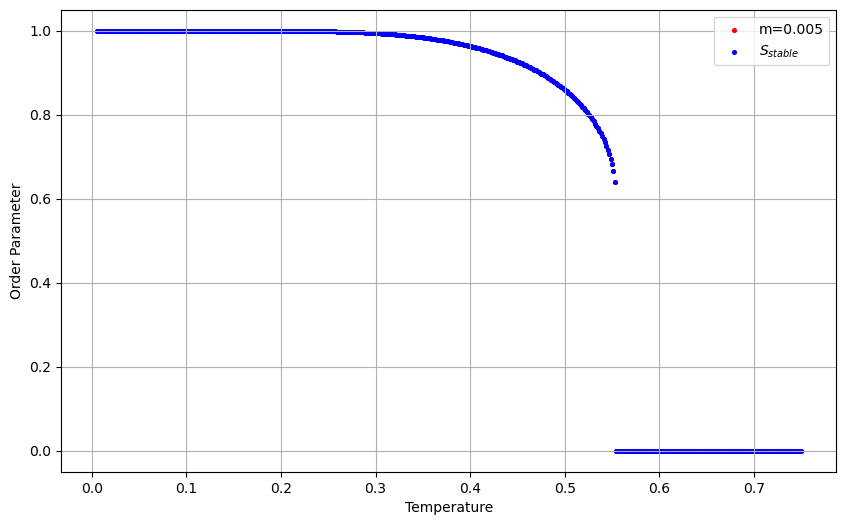

In [2]:
def first_eqs(t,m,S):     
    exp1=np.exp((9/4)*S/t)
    exp2=np.exp((1/4)*(S+4*m)/t) 

    nom = 1 - exp1
    denom = 2 + exp1 + 3*exp2

    return nom/denom + S 

def hessian(t,m,S): 
    exp1=np.exp((9/4)*S/t)
    exp2=np.exp((3*S+4*m)/(4*t))
    exp3=np.exp((3*S+m)/t)

    # Define the denominator
    denominator = 4*t*(2+exp1+3*exp2)**2
    denominator2= 2*t*(2+exp1+3*exp2)**2

    # Define the elements of the Hessian matrix 
    H11 = 1 - 3*(3+3*exp1+5*exp2+exp3)/denominator
    H12 = (9 - 3*exp2*(-4 + exp1))/denominator
    H13 = (9*exp1+3*exp2+6*exp3)/denominator
    H33 =  1 - (9*exp1 + 6*exp3 + 3*exp2)/denominator2


    # Construct the Hessian matrix using numpy
    hessian_matrix = np.array([[H11, H12, H13],
                            [H12, H11, H13],
                        [H13, H13, H33]])
    
    return hessian_matrix


eigenvalues=[] 
def stability_check(t, m, S, tol=1e-8): 
    eigen_values = eigvals(hessian(t, m, S))
    eigenvalues.append(eigen_values)

    return all(ev > -tol for ev in eigen_values)

m=0.005

T_vals = np.linspace(0.005, 0.75, 500)
S_vals = []

S_vals = []
for T in T_vals:
    # Solve for S
    sol = root_scalar(lambda S: first_eqs(T, m, S), method='newton', x0= S_vals[-1] if S_vals else 1.0)

    if sol.converged:
        S_vals.append(sol.root)
    else:
        # Try fallback
        sol = root_scalar(lambda S: first_eqs(T, m, S), method='bisect', bracket=[-1.0, 2.0])
        if sol.converged:
            S_vals.append(sol.root)
        else:
            S_vals.append(np.nan)  # Mark failure

S_stable=[]
T_stable=[]

for i in range(len(T_vals)): 
    if stability_check(T_vals[i],m ,S_vals[i]):
        S_stable.append(S_vals[i]) 
        T_stable.append(T_vals[i]) 


# Plot
fig=plt.figure(figsize=(10, 6))

plt.scatter(T_vals, S_vals, label=f'm={m}', color='red',s=7)
plt.scatter(T_stable, S_stable, label=r'$S_{stable}$', color='blue',s=7) 

plt.xlabel('Temperature')
plt.ylabel('Order Parameter')
plt.legend()
plt.grid(True) 
plt.show() 

## Phase Diagram

In [ ]:
####### Generating Experiments Files
def first_eqs(t,m,S): 
    exp1=np.exp((9/4)*S/t)
    exp2=np.exp((3*S+4*m)/(4*t)) 

    nom = 1 - exp1
    denom = 2 + exp1 + 3*exp2

    return nom/denom + S 

def hessian(t,m,S): 
    exp1=np.exp((9/4)*S/t)
    exp2=np.exp((3*S+4*m)/(4*t))
    exp3=np.exp((3*S+m)/t)

    # Define the denominator
    denominator = 4*t*(2+exp1+3*exp2)**2
    denominator2= 2*t*(2+exp1+3*exp2)**2

    # Define the elements of the Hessian matrix 
    H11 = 1 - 3*(3+3*exp1+5*exp2+exp3)/denominator
    H12 = (9 - 3*exp2*(-4 + exp1))/denominator
    H13 = (9*exp1+3*exp2+6*exp3)/denominator
    H33 =  1 - (9*exp1 + 6*exp3 + 3*exp2)/denominator2

    # Construct the Hessian matrix using numpy
    hessian_matrix = np.array([[H11, H12, H13],
                            [H12, H11, H13],
                        [H13, H13, H33]])
    
    return hessian_matrix

def stability_check(t, m, S, tol=1e-9): 
    
    H = hessian(t, m, S)
    H = (H + H.T) / 2  # Enforce symmetry just in case

    eigen_values = np.real_if_close(eigvals(H))

    return all(ev > tol for ev in eigen_values)

eigenvalues=[]
m_sample = np.linspace(0.01, 0.75, 500)  
n = len(m_sample)
stability_map = np.full((n, n), 0, dtype=float)

for line, m in enumerate(m_sample):
    T_vals = np.linspace(0.01, 0.75, 500)
    S_vals = []

    for t in T_vals:
        # Solve for S
        sol = root_scalar(lambda S: first_eqs(t, m, S), method='newton', x0= S_vals[-1] if S_vals else 1.0)

        if sol.converged:
            S_vals.append(sol.root)
        else:
            # Try fallback
            sol = root_scalar(lambda S: first_eqs(t, m, S), method='bisect', bracket=[-1.0, 2.0])
            if sol.converged:
                S_vals.append(sol.root)
            else:
                S_vals.append(np.nan)  # Mark failure

    for column, (t, S) in enumerate(zip(T_vals, S_vals)):
        if stability_check(t, m, S):
            stability_map[line, column] = S  # Only assign if stable

    # Saving stable points for each m
    stable_indices = np.where(~np.isnan(stability_map[line]))
    S_stable = stability_map[line][stable_indices]
    T_stable = T_vals[stable_indices]

    np.savetxt(f'Data/Uniaxial_{line+1}.csv', np.column_stack((S_stable, T_stable)), 
               delimiter=' ', fmt='%f', header=f'Constant m: {m}\nS_vals T_vals')

np.savetxt('Stability_map.txt', stability_map, delimiter=' ', fmt='%f')

#### Stability Map Plot

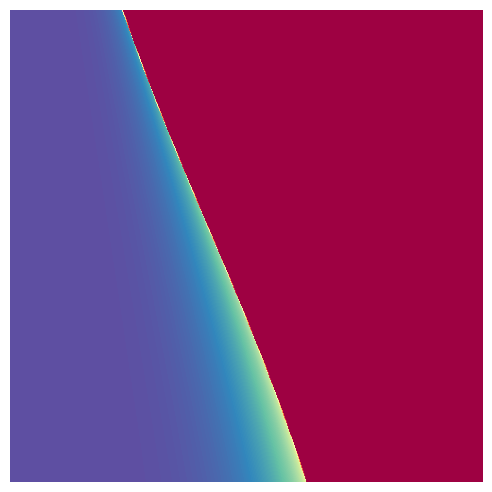

In [13]:
data = np.loadtxt("Stability_map.txt")
data = np.ma.masked_invalid(data) 

cmap='Spectral'
cm = 1/2.54
plt.figure(figsize=(12*cm, 12*cm))  # Adjust for output size in cm
plt.imshow(data, origin='lower', cmap=cmap, extent=[0, 500, 0, 500])
plt.axis('off')  
plt.tight_layout(pad=0)
plt.savefig("heatmap.png", dpi=600, bbox_inches='tight', pad_inches=0, transparent=True)

#### Import colormap
cmap = plt.get_cmap(cmap)
n = 100  # Number of color sample
with open("Spectral_colormap.tex", "w") as f:
    f.write("\\pgfplotsset{\n    colormap={Spectral}{%\n")
    for i in range(n):
        r, g, b, _ = cmap(i / (n - 1))
        f.write(f"        rgb({i})=({r:.4f},{g:.4f},{b:.4f})")
        if i != n - 1:
            f.write(",\n")
        else:
            f.write("\n")
    f.write("    }\n}\n")


#### Transition Line

In [64]:
####### Reading Files 
def file_reader(index): 
    file_path = f'Data/Uniaxial_{index}.csv' 
    data = np.loadtxt(file_path, delimiter=' ', skiprows=2) 
    
    # Extract columns
    S_vals = data[:, 0]
    T_vals = data[:, 1]

    return S_vals, T_vals 

def free_energy(t,S,m): 
    exp1=np.exp(-(3*S+4*m)/(4*t))
    exp2=np.exp((9/4)*S/t) 

    return (3/4)*S**2 - t*np.log(3+exp1*(2+exp2))    

m_sample = np.linspace(0.01, 0.75, 500)

T_c= [] #Critical Temperature Transition 
T_cs= [] #Spinodal Line Temperature
transition_curve = {} 
i = 0 
for idx, m in enumerate(m_sample, 1): 
    # Read data for current sample
    S_vals, T_vals = file_reader(idx)
    delta_e = []

    for j,S in enumerate(S_vals): 
        if S <= 1e-2: 
            transition_curve[i] = {'m': m, 'T': T_vals[j - 1], 'S': S_vals[j - 1]} #Save the transition curve vals (m, T, S) 
            i+=1
            break 
        
    # Compute delta free energy
    for T, S in zip(T_vals, S_vals):     
        delta = free_energy(T, S, m) + T * np.log(3 + 3 * np.exp(-m / T))
        delta_e.append(delta)
        

    # Find transition temperature (where delta crosses zero)
    transition_index = None
    for j in range(len(delta_e) - 1):
        if delta_e[j] < 0 and delta_e[j + 1] >= 0:
            transition_index = j + 1
            break


    if transition_index is not None:
        transition_temperature = T_vals[transition_index]
        T_c.append(transition_temperature)
    else:
        # Handle the case where no transition was found
        T_c.append(np.nan)
        continue  # Skip stability checks if transition not found
    


/var/folders/1q/ck574qds4v36l1t2j4jftvq80000gn/T/ipykernel_42823/3831233270.py:2: RuntimeWarning: divide by zero encountered in log
  return t*np.log((3-4*t)/(4*t))


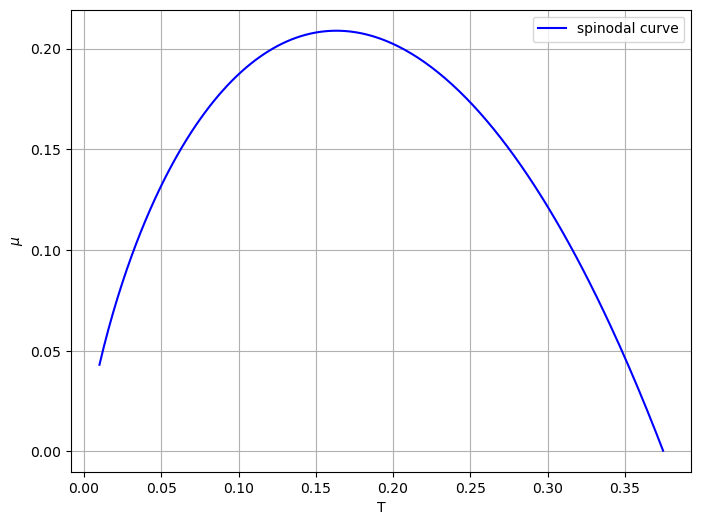

In [146]:
def stability_curve1(t): 
    return t*np.log((3-4*t)/(4*t)) 

curve1 = []
for t in T_stable: 
    curve1.append(stability_curve1(t)) if stability_curve1(t)>=0 else curve1.append(np.nan)

data_s1 = np.column_stack((T_stable, curve1))
np.savetxt("Stability_data1", data_s1, delimiter=" ", fmt="%.6f")

plt.figure(figsize=(8,6)) 
plt.plot(T_stable, curve1, color='blue', label ='spinodal curve')
plt.xlabel('T')
plt.ylabel(r"$\mu$") 
plt.legend()
plt.grid(True)
plt.show()

In [255]:
transition_curve

{0: {'m': 0.01, 'T': 0.472685, 'S': 0.596175},
 1: {'m': 0.011482965931863728, 'T': 0.472685, 'S': 0.585906},
 2: {'m': 0.012965931863727454, 'T': 0.472685, 'S': 0.571934},
 3: {'m': 0.014448897795591182, 'T': 0.471202, 'S': 0.597891},
 4: {'m': 0.01593186372745491, 'T': 0.471202, 'S': 0.587712},
 5: {'m': 0.017414829659318638, 'T': 0.471202, 'S': 0.573959},
 6: {'m': 0.018897795591182362, 'T': 0.469719, 'S': 0.599487},
 7: {'m': 0.02038076152304609, 'T': 0.469719, 'S': 0.589365},
 8: {'m': 0.021863727454909818, 'T': 0.469719, 'S': 0.575749},
 9: {'m': 0.023346693386773545, 'T': 0.468236, 'S': 0.600966},
 10: {'m': 0.024829659318637273, 'T': 0.468236, 'S': 0.590871},
 11: {'m': 0.026312625250501, 'T': 0.468236, 'S': 0.577317},
 12: {'m': 0.02779559118236473, 'T': 0.466754, 'S': 0.60233},
 13: {'m': 0.029278557114228457, 'T': 0.466754, 'S': 0.592232},
 14: {'m': 0.030761523046092185, 'T': 0.466754, 'S': 0.578669},
 15: {'m': 0.03224448897795591, 'T': 0.465271, 'S': 0.60358},
 16: {'m': 

In [88]:
####### Generating Experiments Files
def first_eqs(t,m,S): 
    exp1=np.exp((9/4)*S/t)
    exp2=np.exp((3*S+4*m)/(4*t)) 

    nom = 1 - exp1
    denom = 2 + exp1 + 3*exp2

    return nom/denom + S 

def stability_check(t, m, S, tol=1e-9): 
    
    H = hessian(t, m, S)
    H = (H + H.T) / 2  # Enforce symmetry just in case

    eigen_values = np.real_if_close(eigvals(H))

    return all(ev > tol for ev in eigen_values)

def hessian(t,m,S): 
    exp1=np.exp((9/4)*S/t)
    exp2=np.exp((3*S+4*m)/(4*t))
    exp3=np.exp((3*S+m)/t)

    # Define the denominator
    denominator = 4*t*(2+exp1+3*exp2)**2
    denominator2= 2*t*(2+exp1+3*exp2)**2

    # Define the elements of the Hessian matrix 
    H11 = 1 - 3*(3+3*exp1+5*exp2+exp3)/denominator
    H12 = (9 - 3*exp2*(-4 + exp1))/denominator
    H13 = (9*exp1+3*exp2+6*exp3)/denominator
    H33 =  1 - (9*exp1 + 6*exp3 + 3*exp2)/denominator2

    # Construct the Hessian matrix using numpy
    hessian_matrix = np.array([[H11, H12, H13],
                            [H12, H11, H13],
                        [H13, H13, H33]])
    
    return hessian_matrix


m = 0.03224448897795591
T= 0.466785

sol = root_scalar(lambda S: first_eqs(T, m, S), method='newton', x0= 1.0) 
S = sol.root 
print(S)
print(stability_check(T, m, S))

0.5437696144995683
False


In [93]:
from decimal import Decimal, ROUND_DOWN

def truncate(value, decimals=4):
    # Truncate without rounding
    factor = Decimal('1.' + '0'*decimals)
    return float(Decimal(value).quantize(Decimal(1) / factor, rounding=ROUND_DOWN))

# --- Inputs ---
T = 0.186473
T_trunc = truncate(T, decimals=4)       # -> 0.4652
step = 0.0001                           # step of 0.0001 (4 decimal places)
T_end = 0.19

# --- Create list ---
T_vals = np.arange(T_trunc, T_end + step, step)
print(T_trunc)
print(T_vals[:10])   # first few values
print(T_vals[-1])  

print(T_vals)

0.0
[0.     0.0001 0.0002 0.0003 0.0004 0.0005 0.0006 0.0007 0.0008 0.0009]
0.19
[0.000e+00 1.000e-04 2.000e-04 ... 1.898e-01 1.899e-01 1.900e-01]


In [99]:
m = 0.03224448897795591
T = 0.465271
S = []
T_vals = np.arange(T, T + 0.01, 0.0002) 

for t in T_vals:
    sol = root_scalar(lambda S: first_eqs(t, m, S), method='newton', x0= S[-1] if S else 1.0)
    S.append(sol.root)
    
print(T_vals)
print(S)


[0.465271 0.465471 0.465671 0.465871 0.466071 0.466271 0.466471 0.466671
 0.466871 0.467071 0.467271 0.467471 0.467671 0.467871 0.468071 0.468271
 0.468471 0.468671 0.468871 0.469071 0.469271 0.469471 0.469671 0.469871
 0.470071 0.470271 0.470471 0.470671 0.470871 0.471071 0.471271 0.471471
 0.471671 0.471871 0.472071 0.472271 0.472471 0.472671 0.472871 0.473071
 0.473271 0.473471 0.473671 0.473871 0.474071 0.474271 0.474471 0.474671
 0.474871 0.475071 0.475271]
[0.6035715090372225, 0.5995819759637349, 0.5952436409921094, 0.5904508651924277, 0.5850305323109015, 0.5786597841488972, 0.5705788956429854, 0.5573987849839617, 0.5341722670261316, -4.405816872316759e-18, 1.5162838546346418e-17, -5.2088182777385724e-17, 2.0352259920239605e-17, -6.966022047434557e-17, 1.2702292607353734e-18, -4.3318518773885994e-18, 1.4746088268928132e-17, -5.010641453461372e-17, 1.300818976971138e-17, -4.404169795326232e-17, -7.668337373394987e-18, 2.5869301560500495e-17, 6.896876384335838e-17, -7.5964681268973

In [100]:
for i,s in enumerate(S):
    print(stability_check(T_vals[i], m, s))

True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [109]:

T_spin = []
m_spin = []
s_sol = []
for i, vals in transition_curve.items():
    m = vals['m'] 
    T_c = vals['T'] 

    T_vals = np.arange(T, T + 0.01, 0.0001)  

    for t in T_vals: 
        
        sol = root_scalar(lambda S: first_eqs(t, m, S), method='newton', x0= s_sol[-1] if s_sol else 1.0 )

        if sol.converged:
            S = sol.root 
            s_sol.append(S)
        else:
            # Try fallback
            sol = root_scalar(lambda S: first_eqs(t, m, S), method='bisect', bracket=[-1.0, 2.0])
            if sol.converged:
                S = sol.root 
                s_sol.append(S)
            else:
                S = np.nan 
                s_sol.append(S)  # Mark failure
         
        if S is not np.nan:
            print('in')
            if stability_check(t, m, S) != True: 
                T_spin.append(t)  
                m_spin.append(m)
                break 

in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
i

In [110]:
T_spin

[]

In [259]:
# Example: fit a cubic polynomial T -> mu
def cubic(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

T_spin = np.asarray(T_spin)
m_spin = np.asarray(m_spin, dtype=float)

# --- remove NaN or inf values ---
mask = np.isfinite(T_spin) & np.isfinite(m_spin)
T_clean = T_spin[mask]
m_clean = m_spin[mask]


# --- curve fitting ---
popt, pcov = curve_fit(cubic, T_clean, m_clean)
T_fit = np.linspace(T_clean.min(), T_clean.max(), 400)
m_fit = cubic(T_fit, *popt)

plt.figure(figsize=(8, 6))
plt.scatter(T_spin, m_spin, color="red", s=2, label="spinodal curve")
plt.plot(T_fit, m_fit, "b-", label="cubic fit")
plt.xlabel("T")
plt.ylabel(r"$\mu$")
plt.legend()
plt.grid(True)
plt.show()

# --- save fitted values at original (non-NaN) points ---
fitted_values = cubic(T_clean, *popt)
data3 = np.column_stack((T_clean, fitted_values))
np.savetxt("Spinodal_data", data3, delimiter=" ", fmt="%.6f")

ValueError: `ydata` must not be empty!

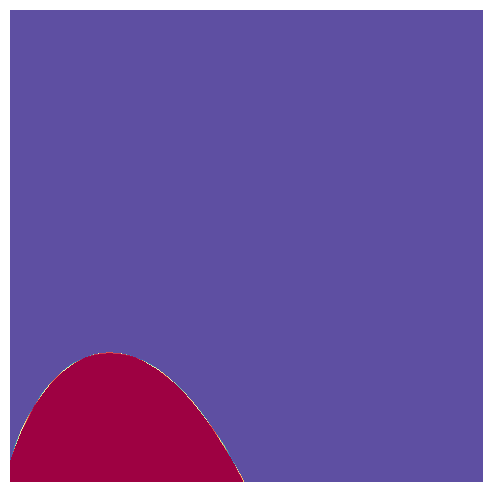

In [213]:
sample_map = np.full((len(transition_curve), len(transition_curve)), 0, dtype=float)

for i, vals in transition_curve.items():
    
    #m, S = vals['m'], vals['S']
    m, S = vals['m'], 0
    #print(m,S)
    T_vals = np.linspace(0.01, 0.75, 500)

    for j, t in enumerate(T_vals):
        if j >= len(sample_map): 
            break 
        else:
            sample_map[i, j] = 1 if stability_check(t, m, S) else 0 

np.savetxt('Sample_map.txt', sample_map, delimiter=' ', fmt='%f') 


cmap='Spectral'
cm = 1/2.54
plt.figure(figsize=(12*cm, 12*cm))  # Adjust for output size in cm
plt.imshow(sample_map, origin='lower', cmap=cmap, extent=[0, 500, 0, 500])
plt.axis('off')  
plt.tight_layout(pad=0)

In [211]:
sample_map

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [ ]:

def expr1(s, t, mu):
    return 1 - 9 / (4 * (2 + np.exp(9*s/(4*t)) + 3*np.exp((3*s + 4*mu)/(4*t))) * t)

def expr2(s, t, mu):
    num = 27*np.exp(9*s/(4*t)) + 9*np.exp(mu/t)*(np.exp(3*s/(4*t)) + 2*np.exp(3*s/t))
    den = 4 * (2 + np.exp(9*s/(4*t)) + 3*np.exp((3*s + 4*mu)/(4*t)))**2 * t
    return 1 - num/den


def solve_T_for_pair(s, t):
    
    sol = root_scalar(lambda mu: expr1(s, t, mu), method='newton', x0= 1.0)

    if sol.converged:
        return sol.x[0]
    else:
        # Try fallback
        sol = root_scalar(lambda mu: expr1(s, t, mu), method='bisect', bracket=[-1.0, 2.0])
        return sol.x[0] if sol.converged else np.nan

    
# Example loop over your dictionary:
mu_results = {}

for i, vals in transition_curve.items():
    S = vals['S']
    m = vals['m']
    
    mu_val = solve_T_for_pair(S,T)

    mu_results[i] = {'T': T, 'S': S, 'mu': mu_val}


ValueError: f(a) and f(b) must have different signs

In [125]:
mu_results

{}

#### Smothing the curve 

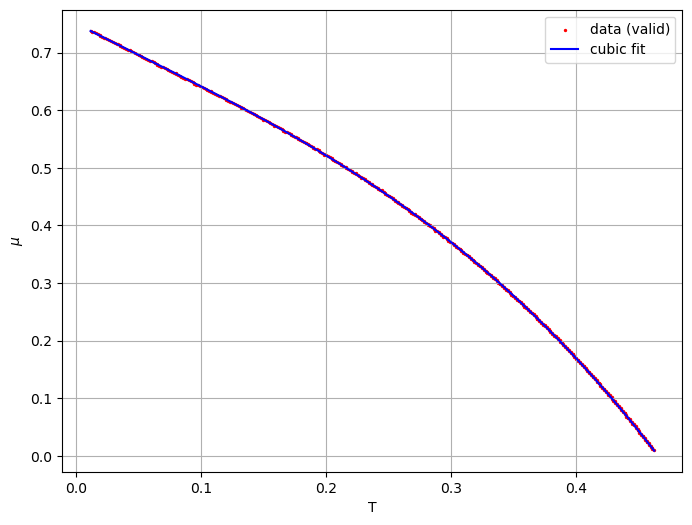

Fit parameters: [-3.32658252  0.45235252 -1.10185631  0.75031679]


In [74]:
# Example: fit a cubic polynomial T -> mu
def cubic(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

T_c = np.asarray(T_c)
m_sample = np.asarray(m_sample, dtype=float)

# --- remove NaN or inf values ---
mask = np.isfinite(T_c) & np.isfinite(m_sample)
T_clean = T_c[mask]
m_clean = m_sample[mask]


# --- curve fitting ---
popt, pcov = curve_fit(cubic, T_clean, m_clean)
T_fit = np.linspace(T_clean.min(), T_clean.max(), 400)
m_fit = cubic(T_fit, *popt)

# --- plotting ---
plt.figure(figsize=(8, 6))
plt.scatter(T_clean, m_clean, color="red", s=2, label="data (valid)")
plt.plot(T_fit, m_fit, "b-", label="cubic fit")
plt.xlabel("T")
plt.ylabel(r"$\mu$")
plt.legend()
plt.grid(True)
plt.show()

# --- save fitted values at original (non-NaN) points ---
fitted_values = cubic(T_clean, *popt)
data2 = np.column_stack((T_clean, fitted_values))
np.savetxt("DMS_data", data2, delimiter=" ", fmt="%.6f")

print("Fit parameters:", popt)

### Energy Analysis

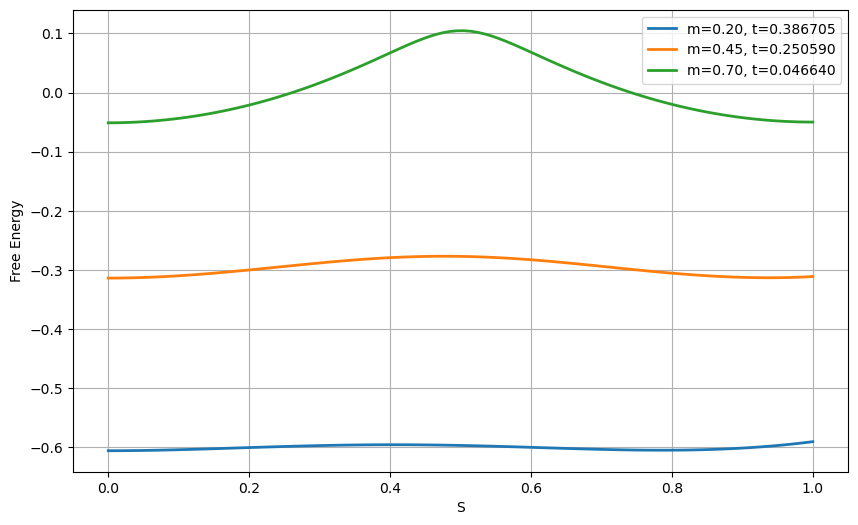

In [209]:
def free_energy(t,S,m): 
    exp1=np.exp(-(3*S+4*m)/(4*t))
    exp2=np.exp((9/4)*S/t) 

    return (3/4)*S**2 - t*np.log(3+exp1*(2+exp2))    

def find_nearest(array, value):     
    array = np.asarray(array)   
    idx = (np.abs(array - value)).argmin()    
    return idx

i=0
m_sample = np.linspace(0.01, 0.75, 500)  
m_vals= [0.2, 0.45, 0.7]
t_sample= [Tc_hat[find_nearest(m_sample,m_vals[0])], Tc_hat[find_nearest(m_sample,m_vals[1])], Tc_hat[find_nearest(m_sample,m_vals[2])]] 
S_sample= np.linspace(0.0, 1.0, 100) 

fig=plt.figure(figsize=(10, 6))

for m,t in zip(m_vals,t_sample): 
    energy = []
    i+=1
     
    for s in S_sample:
        energy.append(free_energy(t,s,m))

    #Save the data     
    data = np.column_stack((S_sample, energy))
    np.savetxt(f'DMS_Energy_{i}', data , delimiter=' ', fmt='%f') 
    
    # Plot the curves
    plt.plot(S_sample, energy, linewidth=2, label=f'm={m:.2f}, t={t:.6f}')

# Plot settings
plt.xlabel('S')
plt.ylabel('Free Energy')
plt.grid(True)
plt.legend()
plt.show()

### Landau Expansion Analysis 

In [ ]:
def self_consitent_eq(t,mu): 
    exp1 = np.exp(mu/t) 

    return (3/4)*(1/(exp1+1)) 

m_sample = np.linspace(0.01, 0.75, 500)  
s_vals = [] 

